# Engineering From Scratch

## Contents:<a class="anchor" id="contents"></a>
* [Setup, Data preparation and Callbacks](#setup)
* [CNN Model](#cnn)
* [G-CNN Model](#g-cnn)
* [Final Evaluation and Comparison](#eval)

## Setup, Data preparation and Callbacks <a class="anchor" id="setup"></a>
----------------------------------

In [1]:
%load_ext jupyternotify
import time
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from keras import models, layers, optimizers, regularizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras import Input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras
import os, shutil
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras_gcnn.layers import GConv2D, GBatchNorm
from keras_gcnn.layers.pooling import GroupPool

#Loading my custom functions from a separate Jupyter notebook
from ipynb.fs.full.my_functions import build_and_compile_model, build_and_compile_model_GCNN, fit_model_to_generator, plot_auc, area_under_ROC_curve
from ipynb.fs.full.my_functions import plot_results,plot_graphs, plot_smooth, plot_smooth_graphs, fit_model_to_directory_generator, evaluate_auc
from ipynb.fs.full.my_functions import build_and_compile_dense_model, crop, memory_required, count_conv_layers
from ipynb.fs.full.my_functions import model_ensemble_evaluation, acc_comparison, save_history, load_history

<IPython.core.display.Javascript object>

Using TensorFlow backend.


### Setting up custom Keras callbacks

In [2]:
class TimeSpent(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times = []
    def on_epoch_begin(self, epoch,logs={}):
        self.time_started = time.time()
    def on_epoch_end(self, epoch,logs={}):
        self.epoch_times.append(time.time()-self.time_started)
        
class LR_modifier(keras.callbacks.Callback):
    def __init__(self,
                 monitor='val_loss',
                 patience=0,
                 verbose=0):
        super(LR_modifier, self).__init__()

        self.monitor = monitor
        self.monitor_op = np.less
        self.patience = patience
        self.verbose = verbose
        self.wait = 0

    def on_train_begin(self, logs=None):
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                curr_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = curr_lr/2.
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait=0
                if(self.verbose==1):
                    print("Learn rate updated from {} to: {}".format(curr_lr,new_lr))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
        return monitor_value

time_check = TimeSpent()
lr_mod = LR_modifier(monitor="val_loss",patience=20,verbose=1)

callbacks = [time_check,
            keras.callbacks.ModelCheckpoint(
                filepath="../model_saves/PCAM/PCAM_Simple/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
#             keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100)
            ]

### Data preparation and generator setup

In [3]:
base_dir = "C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/converted_images/"
tr_dir = os.path.join(base_dir, "train")
va_dir = os.path.join(base_dir, "valid")
te_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64 
targ_size = (96,96)
classification = "binary"

data_generator = datagen.flow_from_directory(
    tr_dir,
    target_size=targ_size,
    batch_size=batch_size,
    class_mode=classification)

Found 262144 images belonging to 2 classes.


#### Taking a sample of the data and loading into memory for ease of use. 

In [15]:
# batch = data_generator.next()

In [16]:
# X = batch[0]
# Y = batch[1]

In [17]:
# for i in range(400):
#     batch = data_generator.next()
#     X = np.append(X,batch[0],axis=0)
#     Y = np.append(Y,batch[1],axis=0)

In [18]:
# X.shape, Y.shape

((25664, 96, 96, 3), (25664,))

#### Saving the sets so they are consistent when the program is restarted.

In [38]:
# np.save("C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/DataSamples/X_Data",X)
# np.save("C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/DataSamples/Y_Data",Y)

In [4]:
X = np.load("C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/DataSamples/X_Data.npy")
Y = np.load("C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/DataSamples/Y_Data.npy")

In [5]:
X.shape, Y.shape

((25664, 96, 96, 3), (25664,))

#### Splitting the data into train, validation and test sets.

In [6]:
valsplit=round(X.shape[0]*0.7)
testsplit=round(X.shape[0]*0.85)

In [7]:
trainX = X[:valsplit]
trainY = Y[:valsplit]

valX = X[valsplit:testsplit]
valY = Y[valsplit:testsplit]

testX = X[testsplit:]
testY = Y[testsplit:]

In [8]:
trainX.shape,trainY.shape,valX.shape,valY.shape,testX.shape,testY.shape

((17965, 96, 96, 3),
 (17965,),
 (3849, 96, 96, 3),
 (3849,),
 (3850, 96, 96, 3),
 (3850,))

#### Showing the sets are evenly balanced between the classes.

In [9]:
len(trainY)/np.count_nonzero(trainY),len(valY)/np.count_nonzero(valY),len(testY)/np.count_nonzero(testY)

(2.0070383197408113, 1.9577822990844354, 2.032734952481521)

#### Showing that all images are unique, with no overlap between sets.

In [27]:
len(np.unique(np.concatenate((trainX,valX,testX),axis=0),axis=1))

25664

## CNN Models <a class="anchor" id="cnn"></a>
----------------------------------

In [28]:
simpleA =  build_and_compile_model(2,["maxpool","conv4","maxpool","globalavg"])

In [29]:
%%notify
historyA = simpleA.fit(trainX,trainY,batch_size=64,epochs=15,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeA = np.sum(time_check.epoch_times)
simpleA.save_weights("../model_saves/PCAM/PCAM_Simple/simpleAFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

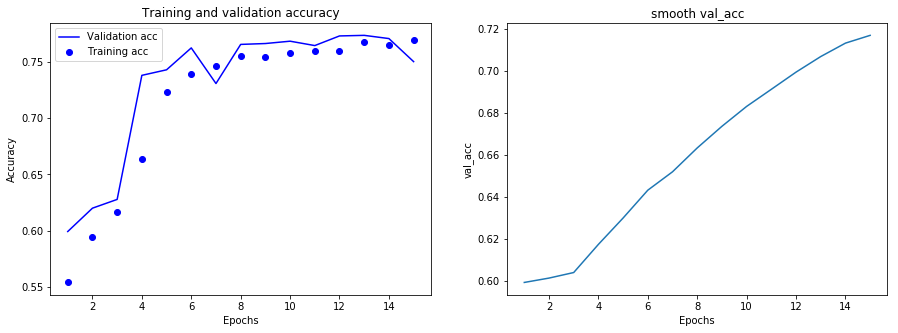

Highest val accuracy: x= 12, y= 0.7737074565131746


<Figure size 432x288 with 0 Axes>

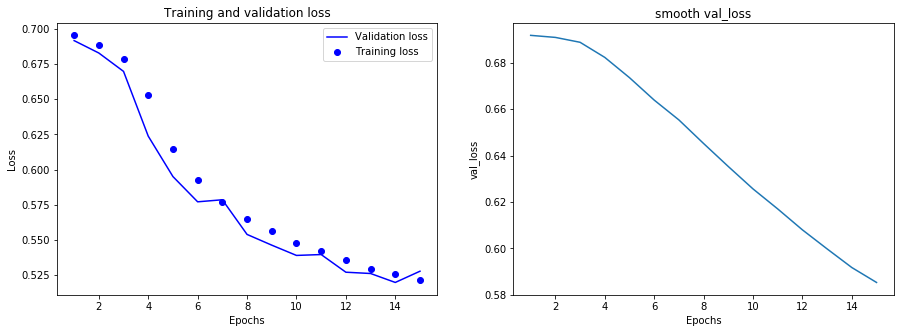

Lowest val loss: x= 13, y= 0.5195971985828353
53.368284702301025


In [41]:
plot_graphs(historyA)
print(timeA)

In [31]:
simpleB =  build_and_compile_model(4,["maxpool","conv8","maxpool","globalavg"])

In [32]:
%%notify
historyB = simpleB.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeB = np.sum(time_check.epoch_times)
simpleB.save_weights("../model_saves/PCAM/PCAM_Simple/simpleBFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

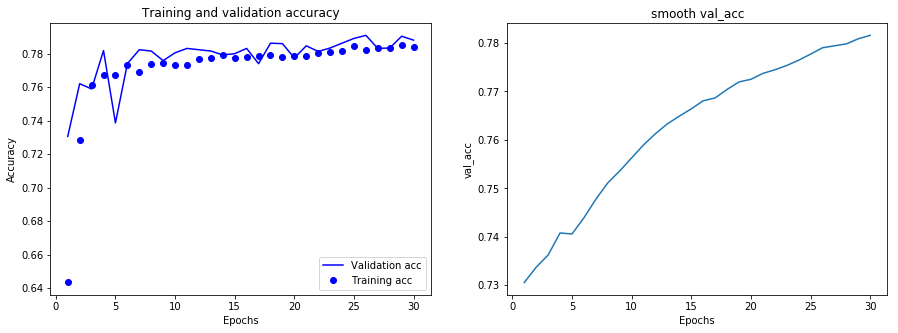

Highest val accuracy: x= 25, y= 0.7908547675030422


<Figure size 432x288 with 0 Axes>

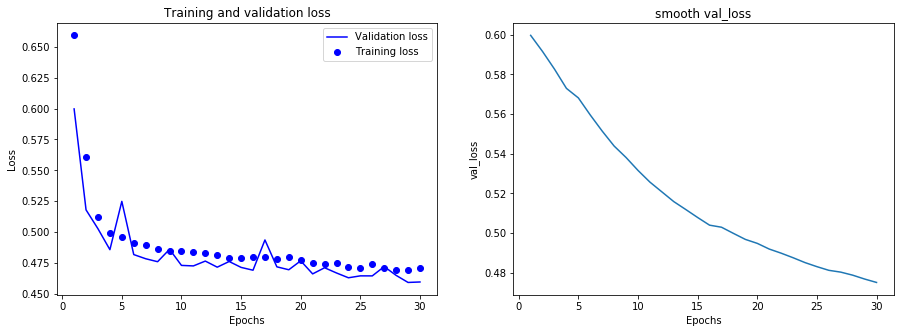

Lowest val loss: x= 28, y= 0.459339559666675
100.87825345993042


In [39]:
plot_graphs(historyB)
print(timeB)

In [34]:
simpleC =  build_and_compile_model(16,["maxpool","conv32","maxpool","conv32","maxpool","globalavg"])

In [35]:
%%notify
historyC = simpleC.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeC = np.sum(time_check.epoch_times)
simpleC.save_weights("../model_saves/PCAM/PCAM_Simple/simpleCFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

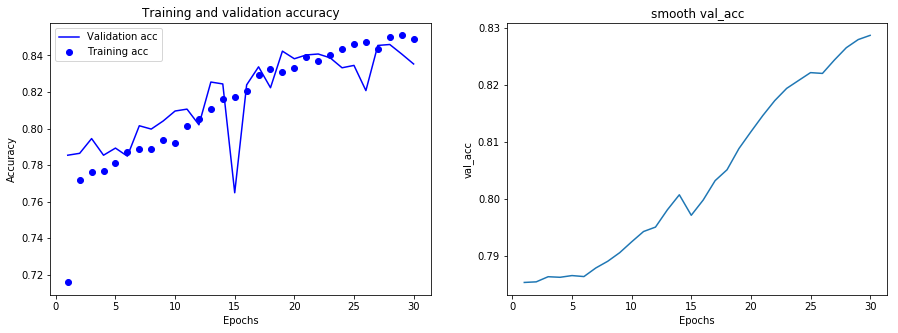

Highest val accuracy: x= 27, y= 0.8459340088334633


<Figure size 432x288 with 0 Axes>

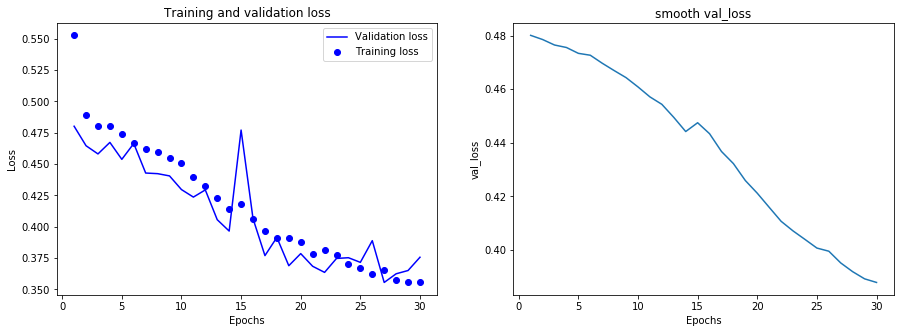

Lowest val loss: x= 26, y= 0.3556199650751767
137.77213072776794


In [40]:
plot_graphs(historyC)
print(timeC)

In [45]:
simpleD =  build_and_compile_model(32,["maxpool","conv64","maxpool","conv64","maxpool","globalavg"])

In [46]:
%%notify
historyD = simpleD.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeD = np.sum(time_check.epoch_times)
simpleD.save_weights("../model_saves/PCAM/PCAM_Simple/simpleDFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

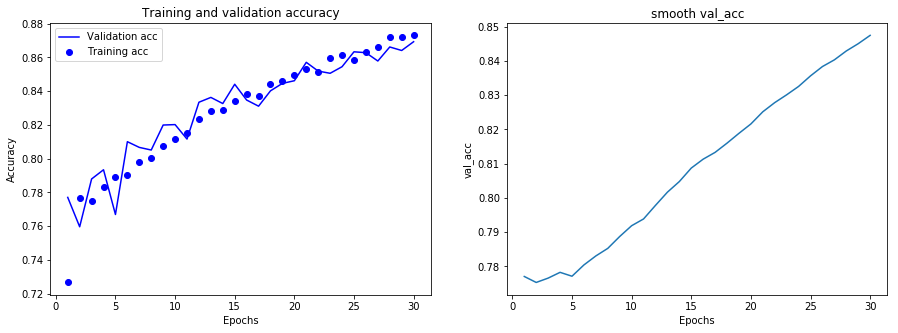

Highest val accuracy: x= 29, y= 0.869316705637828


<Figure size 432x288 with 0 Axes>

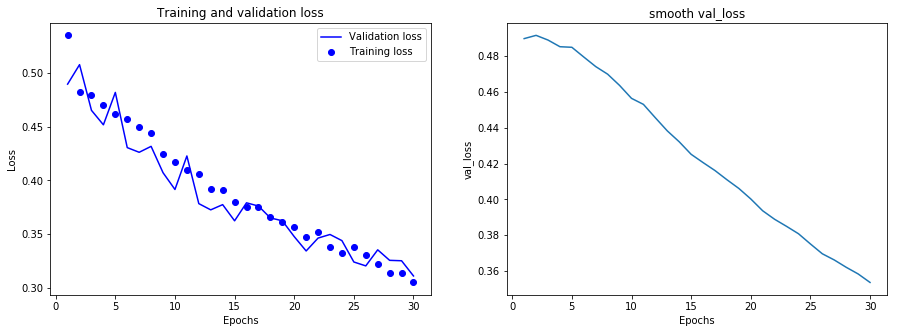

Lowest val loss: x= 29, y= 0.3108416038496862
181.73052549362183


In [47]:
plot_graphs(historyD)
print(timeD)

In [42]:
simpleE =  build_and_compile_model(64,["maxpool","conv128","maxpool","conv128","maxpool","conv128","maxpool","globalavg"])

In [43]:
%%notify
historyE = simpleE.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeE = np.sum(time_check.epoch_times)
simpleD.save_weights("../model_saves/PCAM/PCAM_Simple/simpleEFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

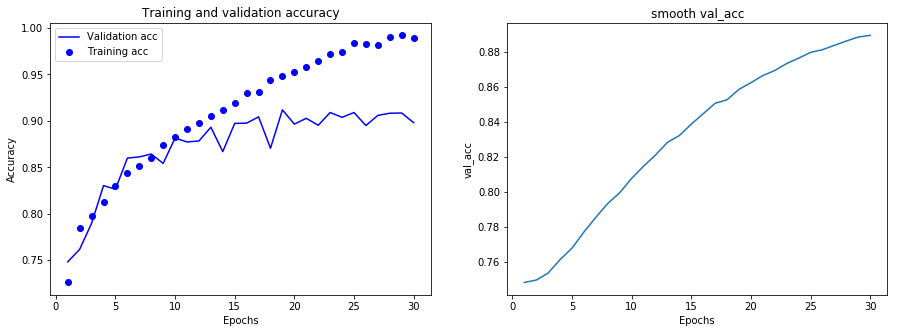

Highest val accuracy: x= 18, y= 0.911925175370226


<Figure size 432x288 with 0 Axes>

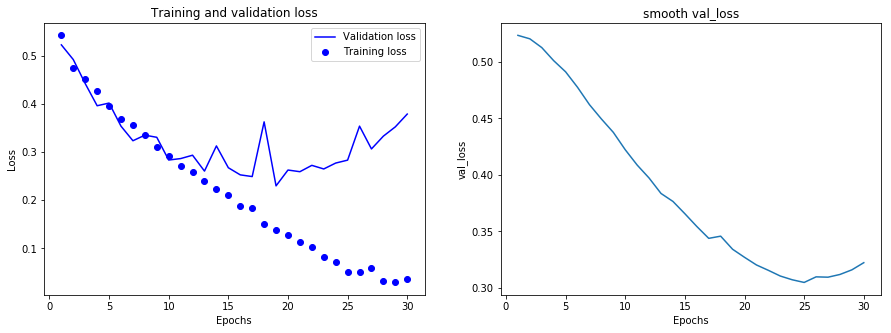

Lowest val loss: x= 18, y= 0.23003312300287707
323.825731754303


In [44]:
plot_graphs(historyE)
print(timeE)

#### Overfitting achieved, regularising with dropout.

In [48]:
simpleF =  build_and_compile_model(64,["maxpool","dropout0.2","conv128","maxpool","dropout0.2","conv128",
                                       "maxpool","dropout0.2","conv128","maxpool","dropout0.2","globalavg"])

In [49]:
%%notify
historyF = simpleF.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeF = np.sum(time_check.epoch_times)
simpleF.save_weights("../model_saves/PCAM/PCAM_Simple/simpleFFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

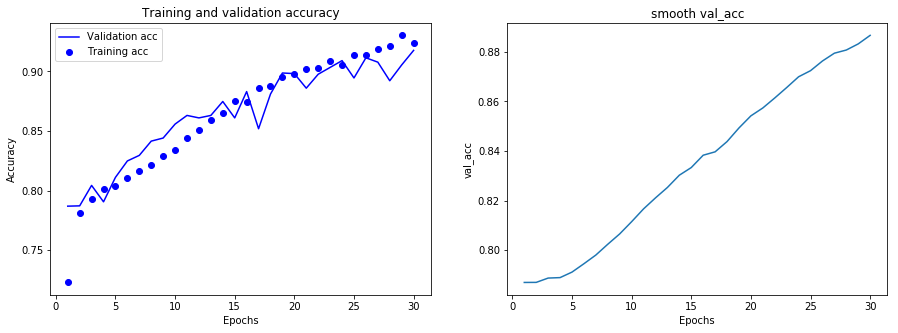

Highest val accuracy: x= 29, y= 0.9176409457001818


<Figure size 432x288 with 0 Axes>

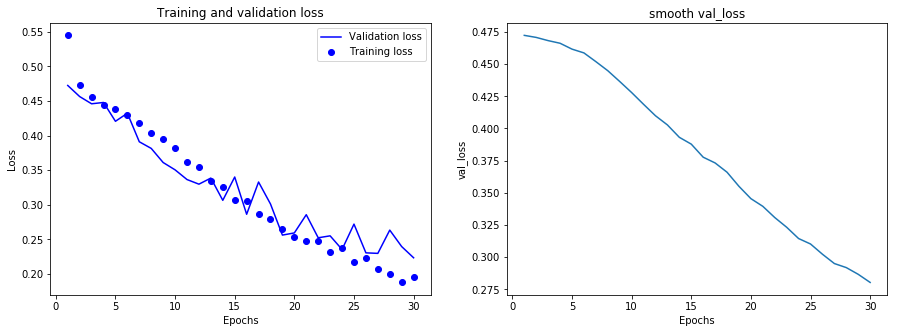

Lowest val loss: x= 29, y= 0.22359983515305065
375.6540195941925


In [50]:
plot_graphs(historyF)
print(timeF)

#### Running for more epochs.

In [51]:
simpleG = build_and_compile_model(64,["maxpool","dropout0.2","conv128","maxpool","dropout0.2","conv128",
                                       "maxpool","dropout0.2","conv128","maxpool","dropout0.2","globalavg"])

In [52]:
%%notify
historyG = simpleG.fit(trainX,trainY,batch_size=64,epochs=60,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeG = np.sum(time_check.epoch_times)
simpleG.save_weights("../model_saves/PCAM/PCAM_Simple/simpleGFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

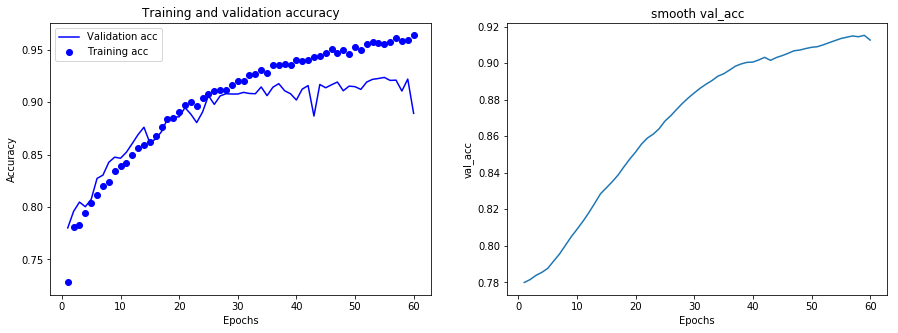

Highest val accuracy: x= 54, y= 0.9236165237724084


<Figure size 432x288 with 0 Axes>

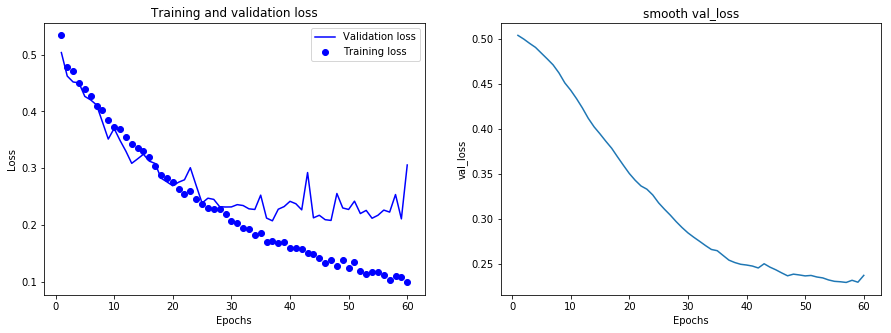

Lowest val loss: x= 36, y= 0.2070803978821811
765.8299551010132


In [53]:
plot_graphs(historyG)
print(timeG)

#### Increasing the dropout and importantly adding weight regulation to the convolutional layers.

In [62]:
simpleH = build_and_compile_model(64,["maxpool","dropout0.3","convreg128","maxpool","dropout0.3","convreg128",
                                       "maxpool","dropout0.3","convreg128","maxpool","dropout0.3","globalavg"])

In [63]:
%%notify
historyH = simpleH.fit(trainX,trainY,batch_size=64,epochs=60,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeH = np.sum(time_check.epoch_times)
simpleH.save_weights("../model_saves/PCAM/PCAM_Simple/simpleHFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

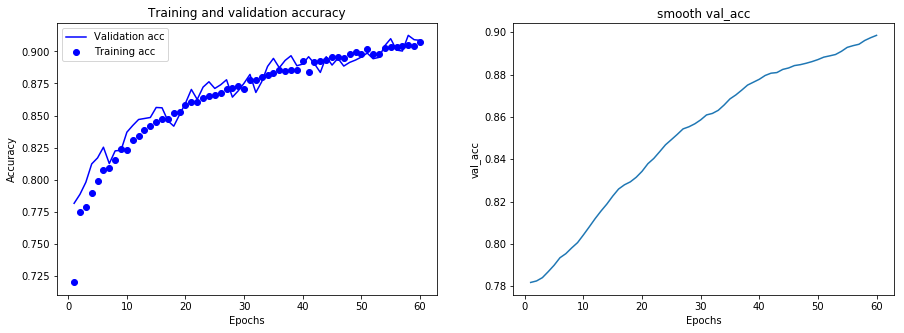

Highest val accuracy: x= 57, y= 0.9124447908547675


<Figure size 432x288 with 0 Axes>

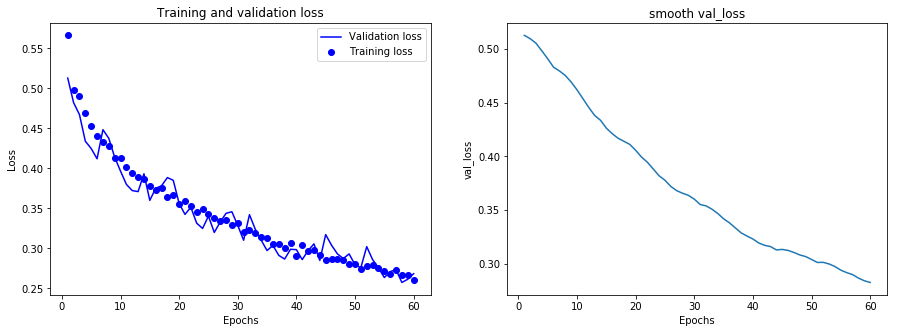

Lowest val loss: x= 57, y= 0.25742940285873894
757.0127024650574


In [64]:
plot_graphs(historyH)
print(timeH)

#### Increasing the epochs

In [65]:
simpleI = build_and_compile_model(64,["maxpool","dropout0.3","convreg128","maxpool","dropout0.3","convreg128",
                                       "maxpool","dropout0.3","convreg128","maxpool","dropout0.3","globalavg"])

In [66]:
%%notify
historyI = simpleI.fit(trainX,trainY,batch_size=64,epochs=120,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeI = np.sum(time_check.epoch_times)
simpleI.save_weights("../model_saves/PCAM/PCAM_Simple/simpleIFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

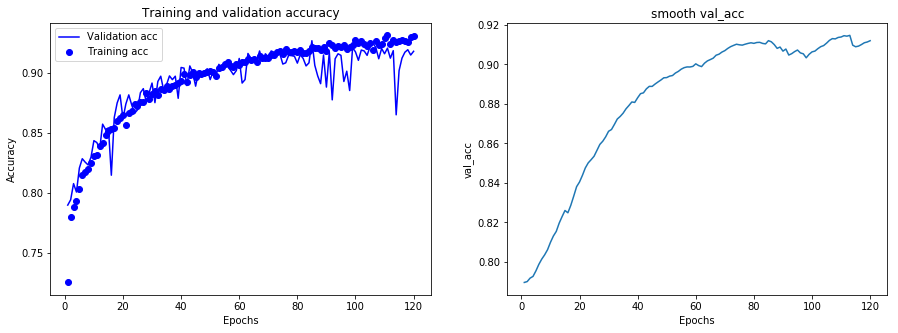

Highest val accuracy: x= 84, y= 0.926734216679657


<Figure size 432x288 with 0 Axes>

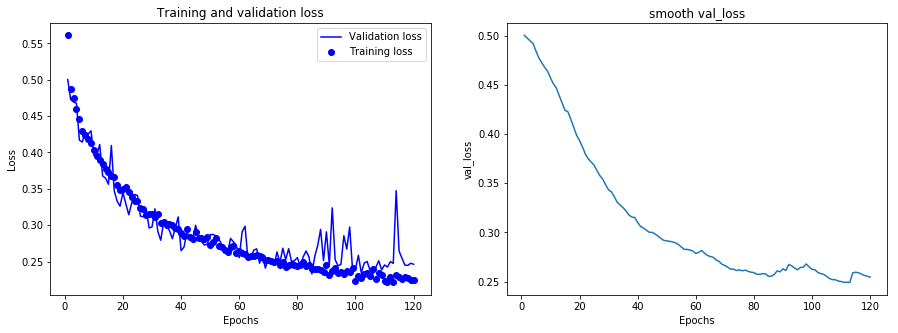

Lowest val loss: x= 84, y= 0.23278759446921335
1558.8146438598633


In [67]:
plot_graphs(historyI)
print(timeI)

#### Training the final CNN model on all of the train+validation data

In [16]:
trainAndValX = np.concatenate((trainX,valX),axis=0)
trainAndValY = np.concatenate((trainY,valY),axis=0)

In [42]:
simpleCNNFinal = build_and_compile_model(64,["maxpool","dropout0.3","convreg128","maxpool","dropout0.3","convreg128",
                                       "maxpool","dropout0.3","convreg128","maxpool","dropout0.3","globalavg"])

In [79]:
%%notify
historyCNNFinal = simpleCNNFinal.fit(trainAndValX,trainAndValY,validation_split=0.05,batch_size=64,epochs=120,callbacks=callbacks,verbose=0)
timeCNNFinal = np.sum(time_check.epoch_times)
simpleCNNFinal.save_weights("../model_saves/PCAM/PCAM_Simple/simpleCNNFinalFinal.h5")

<IPython.core.display.Javascript object>

In [53]:
print(timeCNNFinal)

2208.5214631195777


## G-CNN Models <a class="anchor" id="g-cnn"></a>
----------------------------------

In [82]:
simpleA_P4M = build_and_compile_model_GCNN("D4",2,["maxpool","conv4","maxpool","grouppool","globalavg"])

In [84]:
%%notify
historyA_P4M = simpleA_P4M.fit(trainX,trainY,batch_size=64,epochs=15,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeA_P4M = np.sum(time_check.epoch_times)
simpleA_P4M.save_weights("../model_saves/PCAM/PCAM_Simple/simpleA_P4MFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

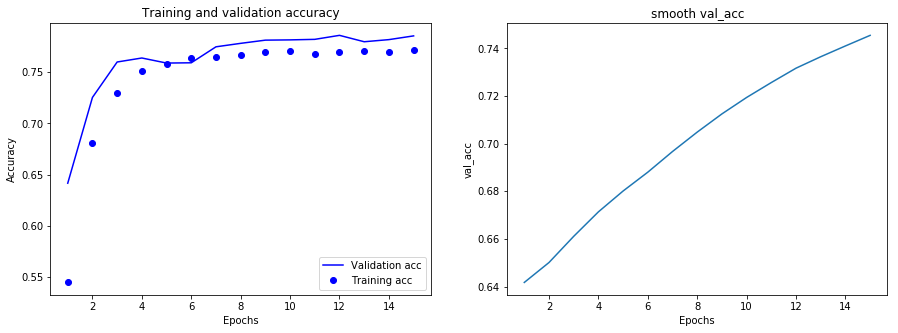

Highest val accuracy: x= 11, y= 0.7859184203998985


<Figure size 432x288 with 0 Axes>

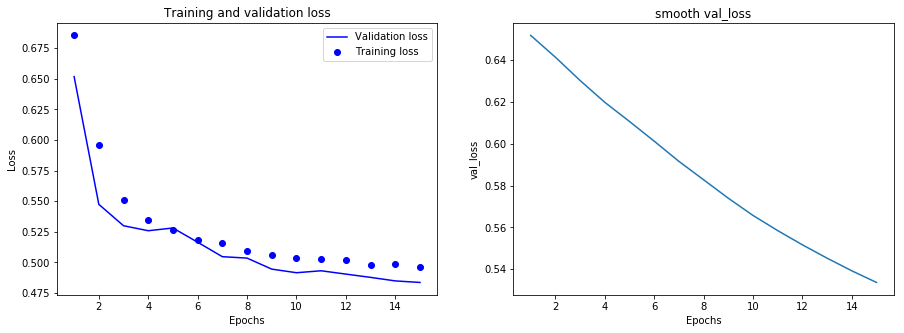

Lowest val loss: x= 14, y= 0.48368616982477614
66.07227993011475


In [86]:
plot_graphs(historyA_P4M)
print(timeA_P4M)

In [94]:
simpleB_P4M = build_and_compile_model_GCNN("D4",4,["maxpool","conv8","maxpool","grouppool","globalavg"])

In [95]:
%%notify
historyB_P4M = simpleB_P4M.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeB_P4M = np.sum(time_check.epoch_times)
simpleB_P4M.save_weights("../model_saves/PCAM/PCAM_Simple/simpleB_P4MFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

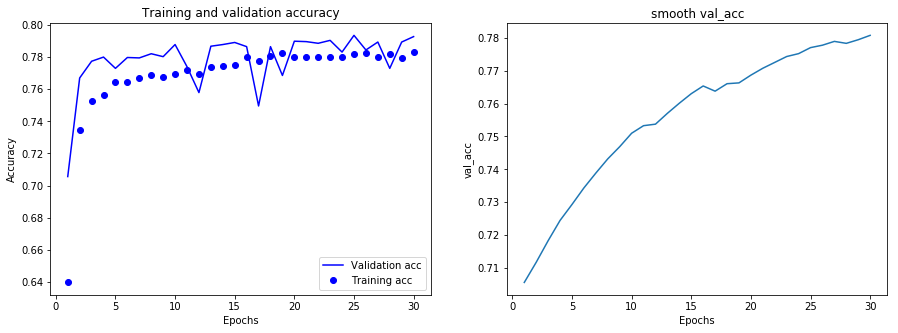

Highest val accuracy: x= 24, y= 0.7934528449257494


<Figure size 432x288 with 0 Axes>

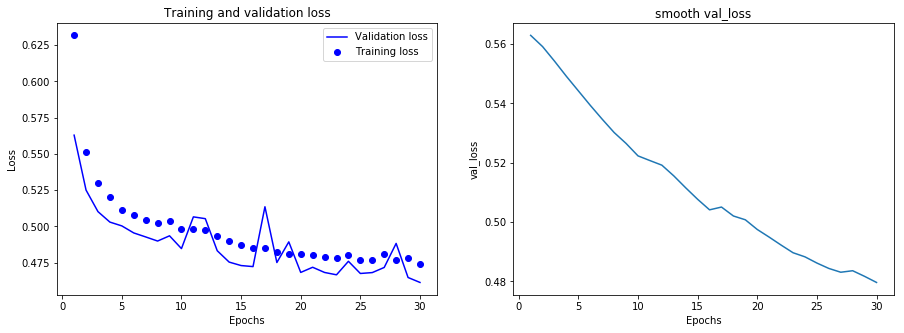

Lowest val loss: x= 29, y= 0.46123028444946507
166.57582807540894


In [96]:
plot_graphs(historyB_P4M)
print(timeB_P4M)

In [97]:
simpleC_P4M = build_and_compile_model_GCNN("D4",8,["maxpool","conv16","maxpool","conv16","maxpool",
                                                   "grouppool","globalavg"])

In [98]:
%%notify
historyC_P4M = simpleC_P4M.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeC_P4M = np.sum(time_check.epoch_times)
simpleC_P4M.save_weights("../model_saves/PCAM/PCAM_Simple/simpleC_P4MFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

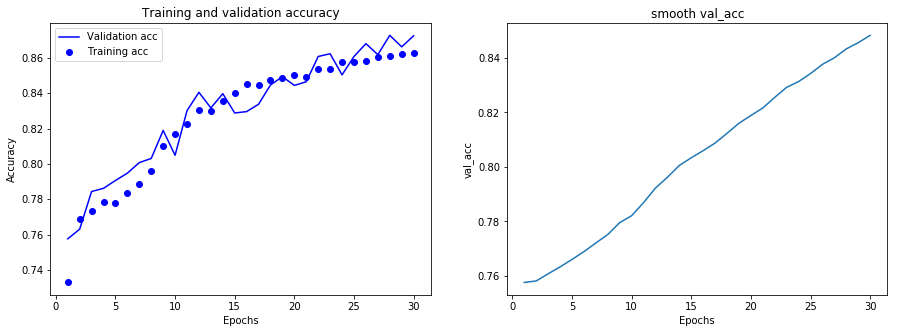

Highest val accuracy: x= 27, y= 0.8726942062873474


<Figure size 432x288 with 0 Axes>

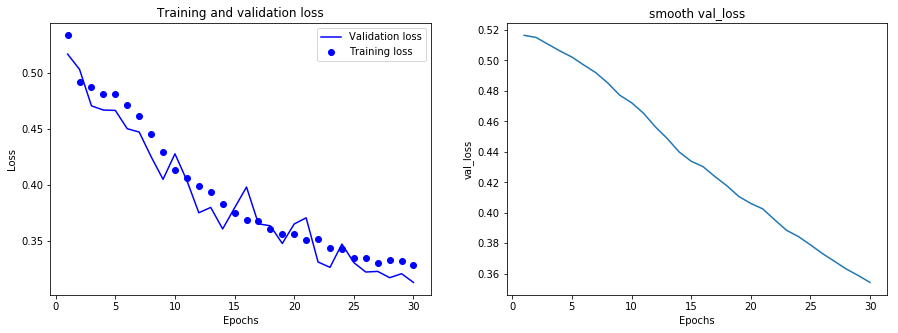

Lowest val loss: x= 29, y= 0.31292175200580774
292.51882553100586


In [99]:
plot_graphs(historyC_P4M)
print(timeC_P4M)

In [103]:
simpleD_P4M = build_and_compile_model_GCNN("D4",16,["maxpool","conv32","maxpool","conv32","maxpool",
                                                    "conv32","maxpool","grouppool","globalavg"])

In [104]:
%%notify
historyD_P4M = simpleD_P4M.fit(trainX,trainY,batch_size=64,epochs=30,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeD_P4M = np.sum(time_check.epoch_times)
simpleD_P4M.save_weights("../model_saves/PCAM/PCAM_Simple/simpleD_P4MFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

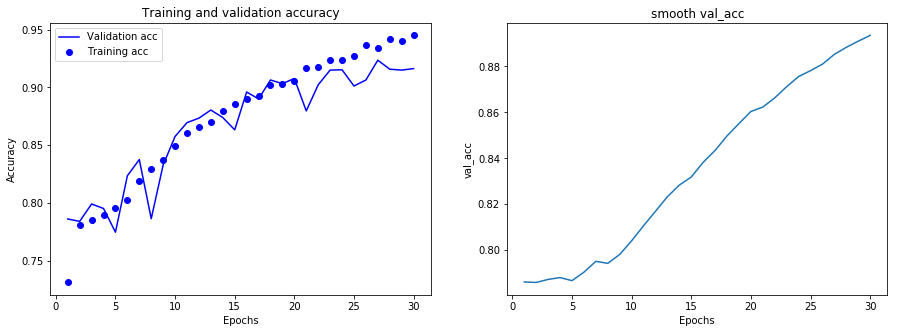

Highest val accuracy: x= 26, y= 0.9236165237724084


<Figure size 432x288 with 0 Axes>

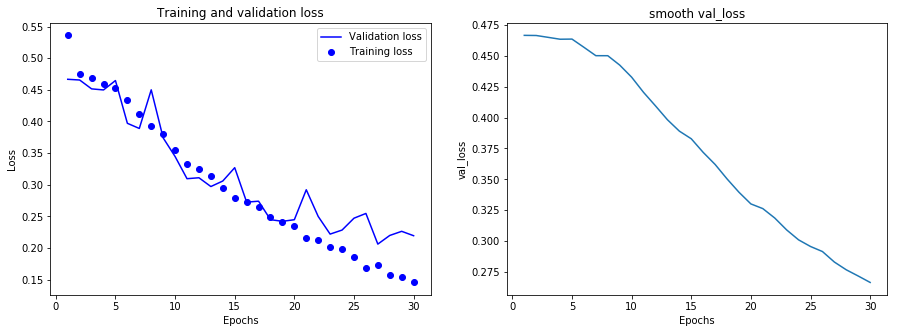

Lowest val loss: x= 26, y= 0.206297864888718
586.8907997608185


In [105]:
plot_graphs(historyD_P4M)
print(timeD_P4M)

#### Achieved overfitting, regularising.

In [106]:
simpleE_P4M = build_and_compile_model_GCNN("D4",16,["maxpool","dropout0.2","conv32","maxpool","dropout0.2","conv32","maxpool",
                                                    "dropout0.2","conv32","maxpool","dropout0.2","grouppool","globalavg"])

In [107]:
%%notify
historyE_P4M = simpleE_P4M.fit(trainX,trainY,batch_size=64,epochs=60,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeE_P4M = np.sum(time_check.epoch_times)
simpleE_P4M.save_weights("../model_saves/PCAM/PCAM_Simple/simpleE_P4MFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

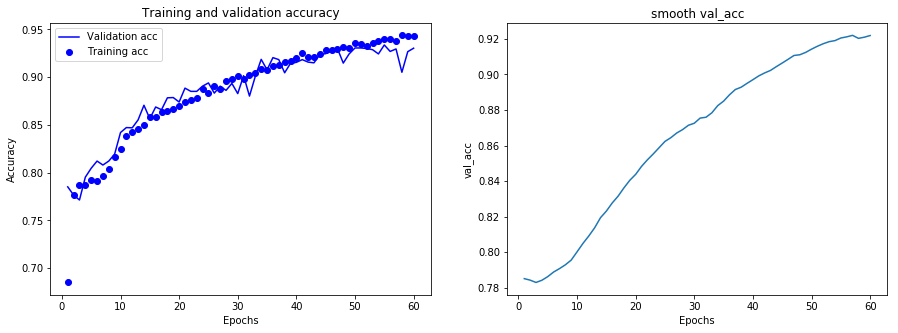

Highest val accuracy: x= 54, y= 0.9337490257209665


<Figure size 432x288 with 0 Axes>

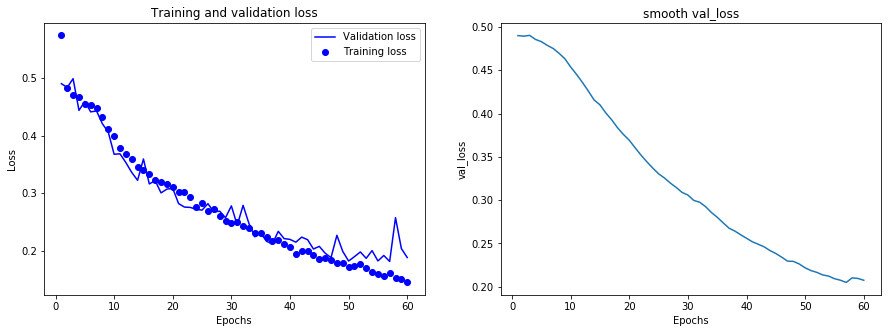

Lowest val loss: x= 56, y= 0.181551523722474
1419.3828189373016


In [108]:
plot_graphs(historyE_P4M)
print(timeE_P4M)

In [109]:
simpleF_P4M = build_and_compile_model_GCNN("D4",16,["maxpool","dropout0.2","convreg32","maxpool","dropout0.2","convreg32","maxpool",
                                                    "dropout0.2","convreg32","maxpool","dropout0.2","grouppool","globalavg"])

In [110]:
%%notify
historyF_P4M = simpleF_P4M.fit(trainX,trainY,batch_size=64,epochs=120,callbacks=callbacks,validation_data=(valX,valY),verbose=0)
timeF_P4M = np.sum(time_check.epoch_times)
simpleF_P4M.save_weights("../model_saves/PCAM/PCAM_Simple/simpleF_P4MFinal.h5")

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

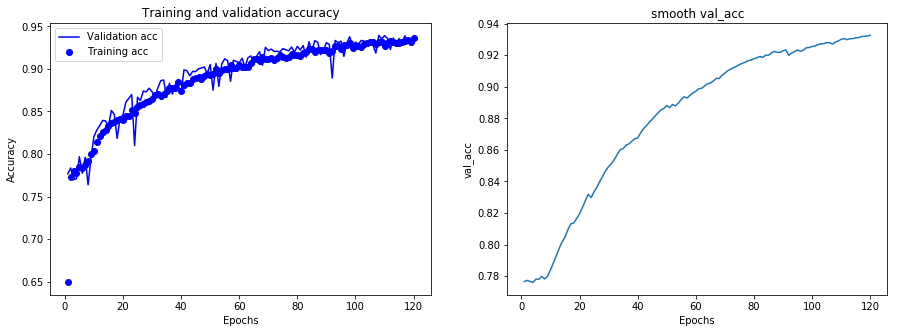

Highest val accuracy: x= 107, y= 0.9394647960509224


<Figure size 432x288 with 0 Axes>

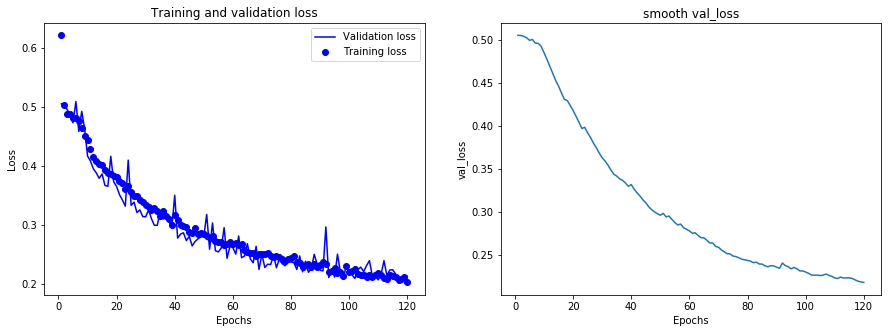

Lowest val loss: x= 117, y= 0.20529483818824368
2835.612968683243


In [111]:
plot_graphs(historyF_P4M)
print(timeF_P4M)

#### Training the final P4M model on all of the train+validation data

In [34]:
simpleP4MFinal = build_and_compile_model_GCNN("D4",16,["maxpool","dropout0.2","convreg32","maxpool","dropout0.2","convreg32","maxpool",
                                                    "dropout0.2","convreg32","maxpool","dropout0.2","grouppool","globalavg"])

In [35]:
%%notify
historyP4MFinal = simpleP4MFinal.fit(trainAndValX,trainAndValY,batch_size=64,epochs=120,callbacks=callbacks,validation_split=0.05,verbose=0)
timeP4MFinal = np.sum(time_check.epoch_times)
simpleP4MFinal.save_weights("../model_saves/PCAM/PCAM_Simple/simpleP4MFinalFinal.h5")

<IPython.core.display.Javascript object>

In [51]:
print(timeP4MFinal)

3087.2242951393127


## Evaluation and Comparison <a class="anchor" id="eval"></a>
----------------------------------

In [50]:
simpleCNNFinal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 64)        1792      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 24, 24, 128)       0         
__________

In [41]:
simpleP4MFinal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
g_conv2d_41 (GConv2D)        (None, 96, 96, 128)       432       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 48, 48, 128)       0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 48, 48, 128)       0         
_________________________________________________________________
g_conv2d_42 (GConv2D)        (None, 48, 48, 256)       36864     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 24, 24, 256)       0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 24, 24, 256)       0         
__________

In [81]:
simpleCNNFinal.evaluate(testX,testY)

3850/3850 [==============================] - 2s 499us/step


[0.2704837405449384, 0.9033766233146965]

In [40]:
simpleP4MFinal.evaluate(testX,testY)

3850/3850 [==============================] - 2s 508us/step


[0.21550129591644585, 0.9306493506493506]

In [61]:
print(timeCNNFinal, timeP4MFinal)

2551.5214631195777 3087.2242951393127
